<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/IE_423_Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Imports and Functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import random
import os
from google.colab import files

In [2]:
#We start with basic statistics for both numeric and categorical data
def unistats(dataframe,sorted="Missing"):
    """"
    Takes dataframe and sorted as parameter
    Returns count, missing, unique, dtype, mode and other stats"""
    pd.set_option("display.max_rows",100)
    pd.set_option("display.max_columns",100)
    output_df = pd.DataFrame(columns = ["Count","Missing","Unique", "Dtype", "Mode", "Mean", "Min", "25%", "Median", "75%", "Max", "Std", "Skew", "Kurt"])

    for col in dataframe:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype ,dataframe[col].mode().values[0], dataframe[col].mean(), dataframe[col].min(), dataframe[col].quantile(0.25), dataframe[col].median(), dataframe[col].quantile(0.75),dataframe[col].max(), dataframe[col].std(), dataframe[col].skew(),dataframe[col].kurt()]
        else:
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype , "-", "-", "-","-", "-", "-","-", "-", "-","-"]


    return output_df.sort_values(by = ["Dtype",sorted])

In [3]:
def get_auc_roc_curve(model):
  from sklearn.metrics import roc_curve, auc
  fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()
  return roc_auc

In [4]:
def upload_dataset(from_drive = False):
  if not os.path.exists("kaggle.json"):
    if not from_drive:
      print("Upload Kaggle API Key")
      files.upload()
      print("Downloading dataset...")
    else:
      !cp /content/drive/MyDrive/kaggle.json /content/
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d zalando-research/fashionmnist
    !unzip fashionmnist.zip
    print("Dataset downloaded")
  else:
    print("Dataset already exists")

In [5]:
upload_dataset()

Upload Kaggle API Key


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 95% 65.0M/68.8M [00:01<00:00, 63.4MB/s]
100% 68.8M/68.8M [00:01<00:00, 62.9MB/s]
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  
Dataset downloaded


# EDA

In [6]:
train = pd.read_csv("fashion-mnist_train.csv")
test = pd.read_csv("fashion-mnist_test.csv")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [8]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [10]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Images are in one layer,i.e,black and white
* 28*28=784 pixels are flattened for ease of use
* We have 10 labels for different cloth types

In [11]:
unistats(train)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
label,60000,0,10,int64,0,4.500000,0,2.0,4.5,7.0,9,2.872305,0.000000,-1.224244
pixel1,60000,0,8,int64,0,0.000900,0,0.0,0.0,0.0,16,0.094689,143.091194,22118.570005
pixel2,60000,0,17,int64,0,0.006150,0,0.0,0.0,0.0,36,0.271011,90.419440,10218.042544
pixel3,60000,0,27,int64,0,0.035333,0,0.0,0.0,0.0,226,1.222324,127.905289,20970.031609
pixel4,60000,0,65,int64,0,0.101933,0,0.0,0.0,0.0,164,2.452871,44.613085,2258.382980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel780,60000,0,251,int64,0,17.911483,0,0.0,0.0,0.0,255,45.149388,2.700864,6.540268
pixel781,60000,0,244,int64,0,8.520633,0,0.0,0.0,0.0,255,29.614859,4.254187,19.470683
pixel782,60000,0,233,int64,0,2.753300,0,0.0,0.0,0.0,255,17.397652,7.961132,71.142610
pixel783,60000,0,185,int64,0,0.855517,0,0.0,0.0,0.0,255,9.356960,14.290953,236.216859


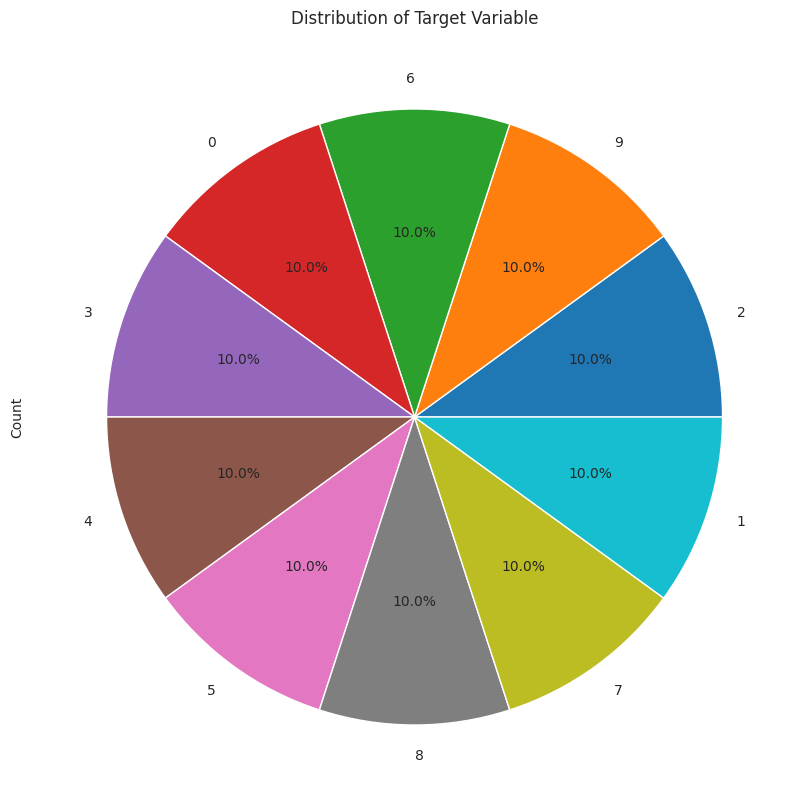

In [12]:
#Lets look at the pie chart of target column
plt.figure(figsize=(10,10))
sns.set_style("darkgrid")
train["label"].value_counts().plot.pie(autopct="%1.1f%%")
plt.title("Distribution of Target Variable")
plt.ylabel("Count")
plt.show()

From the pie chart, I can say that dataset is balanced.

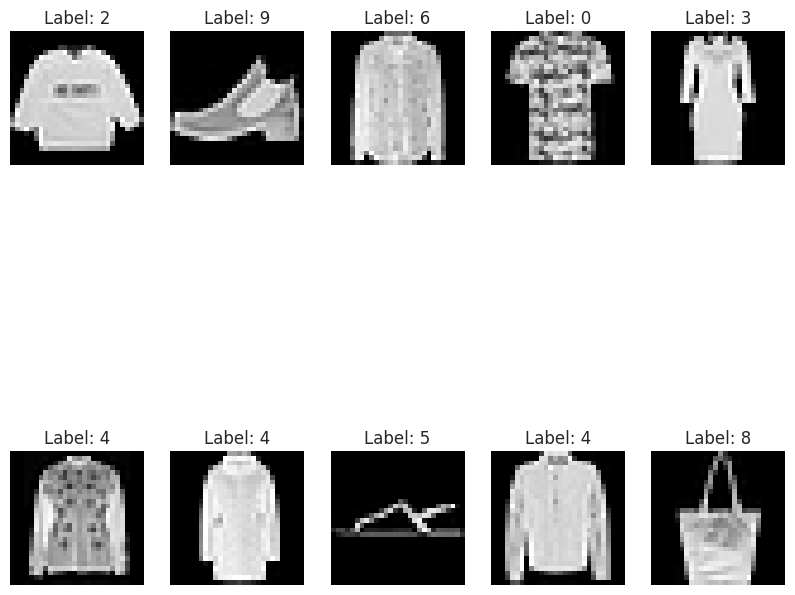

In [13]:
#Lets look at some images
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train.iloc[i, 1:].values.reshape(28, 28), cmap="gray")
    plt.title(f"Label: {train.iloc[i, 0]}")
    plt.axis("off")
plt.show()

Here we can see some of the images constructed from the pixels: shoe, thirt, dress(I guess), and smt I do not know. Here we can see that the images are not too bright or too dark
They are not too noisy either

# Modelling

In [14]:
train = train.astype("float32")
X_train, X_valid, y_train, y_valid = train_test_split(train.iloc[:,1:], train["label"], test_size=0.2, random_state=42)


## Logistic Regression

In [15]:
log_reg_pipe = Pipeline([("scaler", MinMaxScaler()), ("model", LogisticRegression())])
log_reg_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

In [16]:
log_reg_pipe.score(X_valid, y_valid)

0.8549166666666667

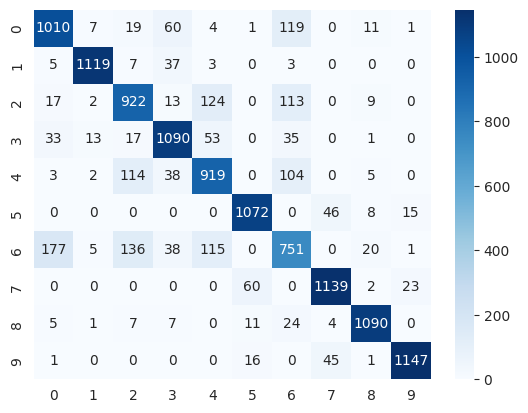

In [17]:
sns.heatmap(confusion_matrix(y_valid, log_reg_pipe.predict(X_valid)), annot=True, cmap="Blues", fmt="d")
plt.show()

The algorithm confuses mostly on the 6th label with 0,2,4. Lets look at what are these?
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

In [18]:
#Lets look at the images with label 0,2,4,6
train[train["label"].isin([0,2,4,6])].head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,...,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,105.0,92.0,101.0,107.0,100.0,132.0,0.0,0.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,227.0,211.0,171.0,191.0,236.0,228.0,172.0,0.0,0.0,0.0,...,253.0,0.0,112.0,255.0,217.0,211.0,227.0,245.0,195.0,194.0,211.0,220.0,214.0,74.0,0.0,255.0,222.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,12.0,0.0,0.0,40.0,134.0,162.0,191.0,214.0,163.0,146.0,165.0,79.0,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,114.0,183.0,112.0,55.0,23.0,72.0,102.0,165.0,160.0,28.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,188.0,163.0,93.0,136.0,153.0,168.0,252.0,174.0,136.0,166.0,130.0,123.0,131.0,...,0.0,5.0,194.0,193.0,204.0,104.0,116.0,241.0,217.0,196.0,171.0,249.0,207.0,197.0,202.0,45.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22.0,21.0,25.0,69.0,52.0,45.0,74.0,39.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,5.0,4.0,5.0,5.0,3.0,5.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,7.0,4.0,4.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,5.0,11.0,2.0,0.0,0.0,21.0,231.0,156.0,134.0,177.0,194.0,1.0,0.0,0.0,0.0,...,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,4.0,9.0,7.0,8.0,7.0,5.0,4.0,8.0,12.0,5.0,7.0,8.0,7.0,4.0,3.0,7.0,5.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0,161.0,143.0,180.0,142.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,251.0,249.0,239.0,254.0,249.0,238.0,255.0,33.0,0.0,3.0,...,0.0,0.0,0.0,198.0,241.0,243.0,247.0,255.0,255.0,255.0,255.0,231.0,241.0,217.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,36.0,50.0,51.0,68.0,48.0,48.0,33.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


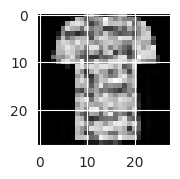

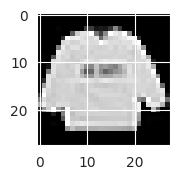

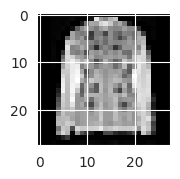

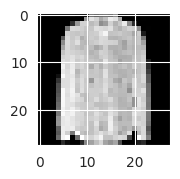

In [19]:
j=0
for i in [0,2,4,6]:
    j+=1
    plt.figure(figsize=(10, 10))
    sns.set_style("darkgrid")
    plt.subplot(5, 2, j)
    plt.imshow(train[train["label"]==i].iloc[0, 1:].values.reshape(28, 28), cmap="gray")

As we can see, tshirt,pullover,coat and shirt tends to confuse

In [20]:
print(classification_report(y_valid, log_reg_pipe.predict(X_valid)))
log_reg_valid_score = log_reg_pipe.score(X_valid, y_valid)

              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81      1232
         1.0       0.97      0.95      0.96      1174
         2.0       0.75      0.77      0.76      1200
         3.0       0.85      0.88      0.86      1242
         4.0       0.75      0.78      0.76      1185
         5.0       0.92      0.94      0.93      1141
         6.0       0.65      0.60      0.63      1243
         7.0       0.92      0.93      0.93      1224
         8.0       0.95      0.95      0.95      1149
         9.0       0.97      0.95      0.96      1210

    accuracy                           0.85     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.85      0.85      0.85     12000



Overall accuracy is 85% on validation data

In [21]:
#Lets look at the cross validation score
scores = cross_val_score(log_reg_pipe, train.iloc[:, 1:], train["label"], cv=5,
                         scoring="accuracy")
print("Cross Validation Scores:", scores)
print("Cross Validation Score Mean:", scores.mean())
log_reg_cv_score = scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross Validation Scores: [0.856      0.8545     0.86       0.85316667 0.8525    ]
Cross Validation Score Mean: 0.8552333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## KNN

In [22]:
knn_pipe = Pipeline([("scaler", MinMaxScaler()), ("model", KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())])

In [23]:
knn_pipe.score(X_valid, y_valid)

0.8559166666666667

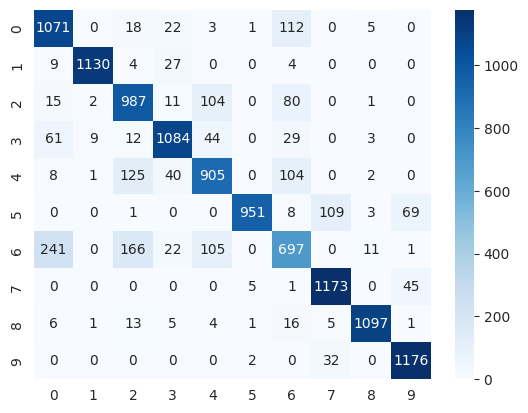

In [24]:
sns.heatmap(confusion_matrix(y_valid, knn_pipe.predict(X_valid)), annot=True, cmap="Blues", fmt="d")
plt.show()

Similar confusion on 0,2,4,6 as Logistic Regression

In [25]:
print(classification_report(y_valid, knn_pipe.predict(X_valid)))
knn_pipe_valid_score = knn_pipe.score(X_valid, y_valid)

              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81      1232
         1.0       0.99      0.96      0.98      1174
         2.0       0.74      0.82      0.78      1200
         3.0       0.90      0.87      0.88      1242
         4.0       0.78      0.76      0.77      1185
         5.0       0.99      0.83      0.91      1141
         6.0       0.66      0.56      0.61      1243
         7.0       0.89      0.96      0.92      1224
         8.0       0.98      0.95      0.97      1149
         9.0       0.91      0.97      0.94      1210

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.85     12000



Overall accuracy is 86% on validation data

In [26]:
scores = cross_val_score(knn_pipe, train.iloc[:, 1:], train["label"], cv=5,
                         scoring="accuracy")
print("Cross Validation Scores:", scores)
print("Cross Validation Score Mean:", scores.mean())
knn_pipe_cv_score = scores.mean()

Cross Validation Scores: [0.85508333 0.85533333 0.85316667 0.85216667 0.85408333]
Cross Validation Score Mean: 0.8539666666666668


## MLP

In [27]:
mlp_pipe = Pipeline([("scaler", MinMaxScaler()), ("model", MLPClassifier())])
mlp_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', MinMaxScaler()), ('model', MLPClassifier())])

In [28]:
mlp_pipe.score(X_valid, y_valid)

0.8780833333333333

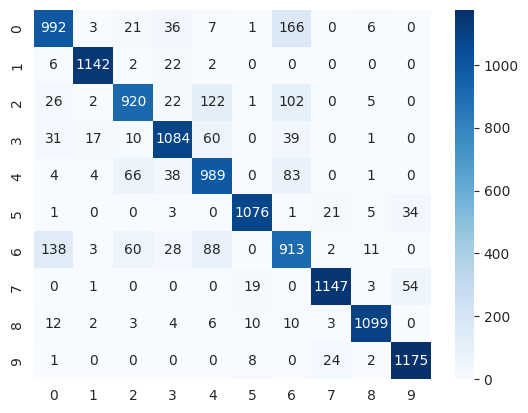

In [29]:
sns.heatmap(confusion_matrix(y_valid, mlp_pipe.predict(X_valid)), annot=True, cmap="Blues", fmt="d")
plt.show()

MLP is performing much better on the 0,2,4,6 differing but having problems in the 4th one this time.

In [30]:
print(classification_report(y_valid, mlp_pipe.predict(X_valid)))
mlp_pipe_valid_score = mlp_pipe.score(X_valid, y_valid)

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81      1232
         1.0       0.97      0.97      0.97      1174
         2.0       0.85      0.77      0.81      1200
         3.0       0.88      0.87      0.87      1242
         4.0       0.78      0.83      0.80      1185
         5.0       0.97      0.94      0.95      1141
         6.0       0.69      0.73      0.71      1243
         7.0       0.96      0.94      0.95      1224
         8.0       0.97      0.96      0.96      1149
         9.0       0.93      0.97      0.95      1210

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



Overall accuracy is 88% on validation data

In [31]:
scores = cross_val_score(mlp_pipe, train.iloc[:, 1:], train["label"], cv=5,
                         scoring="accuracy")
print("Cross Validation Scores:", scores)
print("Cross Validation Score Mean:", scores.mean())
mlp_pipe_cv_score = scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross Validation Scores: [0.882      0.87658333 0.88058333 0.88075    0.88166667]
Cross Validation Score Mean: 0.8803166666666666


##CNN

In [32]:
cnn_model = keras.Sequential([
    keras.layers.Reshape((28,28,1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Above we have Convolution NN with 8 layers.

In [33]:
cnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [34]:
#pipeline with 30 epochs
cnn_model.fit(X_train, y_train, epochs=15,batch_size=150)

Epoch 1/15
320/320 [==============================] - 40s 122ms/step - loss: 1.3398 - accuracy: 0.7613
Epoch 2/15
320/320 [==============================] - 36s 112ms/step - loss: 0.3957 - accuracy: 0.8585
Epoch 3/15
320/320 [==============================] - 34s 108ms/step - loss: 0.3415 - accuracy: 0.8755
Epoch 4/15
320/320 [==============================] - 37s 117ms/step - loss: 0.3031 - accuracy: 0.8892
Epoch 5/15
320/320 [==============================] - 35s 111ms/step - loss: 0.2747 - accuracy: 0.9000
Epoch 6/15
320/320 [==============================] - 35s 111ms/step - loss: 0.2539 - accuracy: 0.9068
Epoch 7/15
320/320 [==============================] - 37s 116ms/step - loss: 0.2356 - accuracy: 0.9129
Epoch 8/15
320/320 [==============================] - 36s 112ms/step - loss: 0.2221 - accuracy: 0.9169
Epoch 9/15
320/320 [==============================] - 38s 118ms/step - loss: 0.2088 - accuracy: 0.9225
Epoch 10/15
320/320 [==============================] - 35s 110ms/step - l

In [35]:
y_pred = cnn_model.predict(X_valid).argmax(axis=1)

375/375 [==============================] - 3s 9ms/step


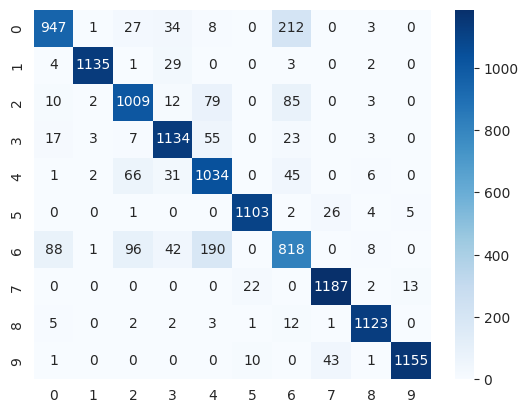

In [36]:
sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, cmap="Blues", fmt="d")
plt.show()

In [37]:
print(classification_report(y_valid, y_pred))
cnn_model_valid_score = cnn_model.evaluate(X_valid, y_valid)[1]

              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82      1232
         1.0       0.99      0.97      0.98      1174
         2.0       0.83      0.84      0.84      1200
         3.0       0.88      0.91      0.90      1242
         4.0       0.76      0.87      0.81      1185
         5.0       0.97      0.97      0.97      1141
         6.0       0.68      0.66      0.67      1243
         7.0       0.94      0.97      0.96      1224
         8.0       0.97      0.98      0.97      1149
         9.0       0.98      0.95      0.97      1210

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000

375/375 [==============================] - 5s 12ms/step - loss: 0.3783 - accuracy: 0.8871


Overall accuracy is 90% on validation data


#XGBoost

In [38]:
xgb_model = xgb.XGBClassifier()
xgb_pipe = Pipeline([("scaler", MinMaxScaler()), ("model", xgb_model)])
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [39]:
xgb_pipe.score(X_valid, y_valid)
y_pred = xgb_pipe.predict(X_valid)

In [40]:
print(classification_report(y_valid, xgb_pipe.predict(X_valid)))
xgb_pipe_valid_score = xgb_pipe.score(X_valid, y_valid)

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      1232
         1.0       1.00      0.97      0.98      1174
         2.0       0.84      0.85      0.84      1200
         3.0       0.89      0.92      0.90      1242
         4.0       0.82      0.84      0.83      1185
         5.0       0.98      0.97      0.97      1141
         6.0       0.75      0.68      0.71      1243
         7.0       0.96      0.97      0.96      1224
         8.0       0.97      0.98      0.97      1149
         9.0       0.98      0.97      0.97      1210

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



Overall accuracy is 90% on validation data

In [41]:
scores = cross_val_score(xgb_pipe, train.iloc[:, 1:], train["label"], cv=5,
                         scoring="accuracy")
print("Cross Validation Scores:", scores)
print("Cross Validation Score Mean:", scores.mean())
xgb_pipe_cv_score = scores.mean()

Cross Validation Scores: [0.90133333 0.9025     0.90425    0.90058333 0.89908333]
Cross Validation Score Mean: 0.9015500000000001


## Test Scores for Each Model

In [42]:
log_reg_test = log_reg_pipe.score(test.iloc[:, 1:], test["label"])
knn_test = knn_pipe.score(test.iloc[:, 1:], test["label"])
mlp_test = mlp_pipe.score(test.iloc[:, 1:], test["label"])
y_pred = cnn_model.predict(test.iloc[:, 1:]).argmax(axis=1)
cnn_test = cnn_model.evaluate(test.iloc[:, 1:], test["label"])[1]
xgb_test = xgb_pipe.score(test.iloc[:, 1:], test["label"])

313/313 [==============================] - 5s 15ms/step - loss: 0.3512 - accuracy: 0.8933


# Comparison

In [43]:
validation_scores = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "MLP", "CNN","XGBoost"],
    "Validation Score": [log_reg_valid_score, knn_pipe_valid_score, mlp_pipe_valid_score, cnn_model_valid_score,xgb_pipe_valid_score]
})
cv_scores = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "MLP","XGBoost"],
    "Cross Validation Score": [log_reg_cv_score, knn_pipe_cv_score, mlp_pipe_cv_score,xgb_pipe_cv_score]
})
test_scores = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "MLP", "CNN","XGBoost"],
    "Test Score": [log_reg_test, knn_test, mlp_test, cnn_test,xgb_test]
})

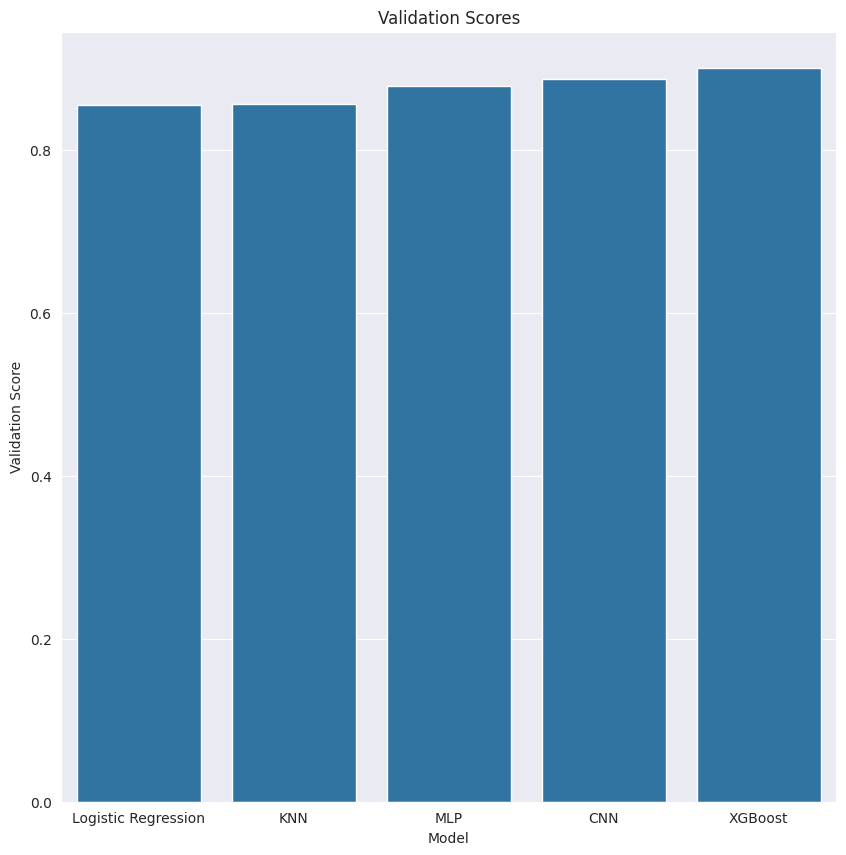

In [44]:
#Lets put all scores in one plot
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
sns.barplot(x="Model", y="Validation Score", data=validation_scores)
plt.title("Validation Scores")
plt.show()

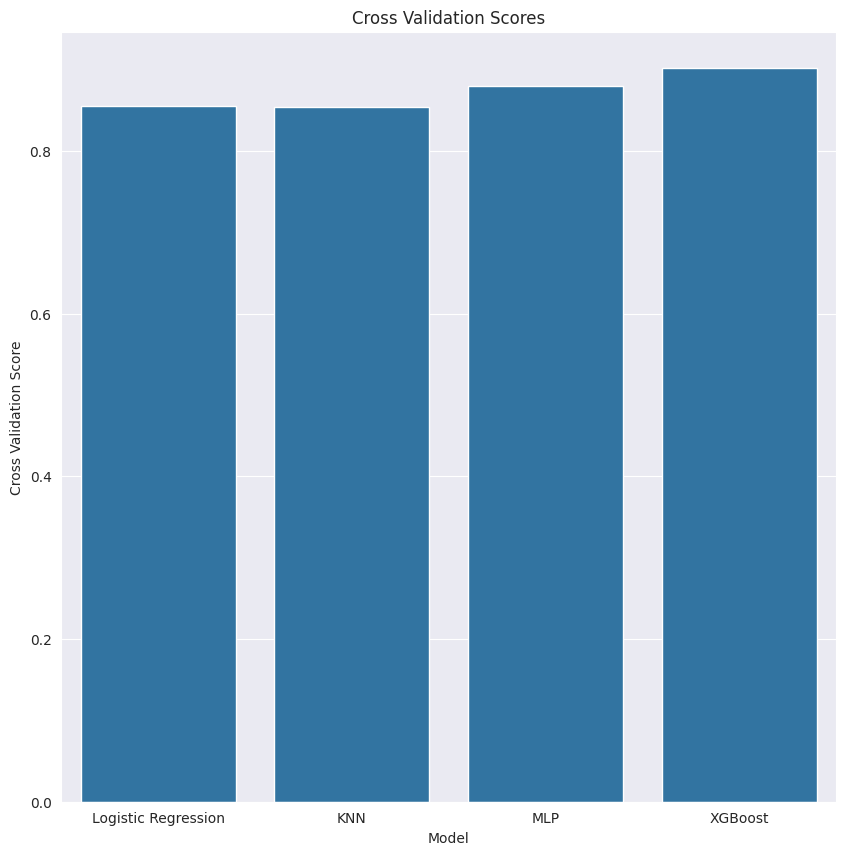

In [45]:
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
sns.barplot(x="Model", y="Cross Validation Score", data=cv_scores)
plt.title("Cross Validation Scores")
plt.show()

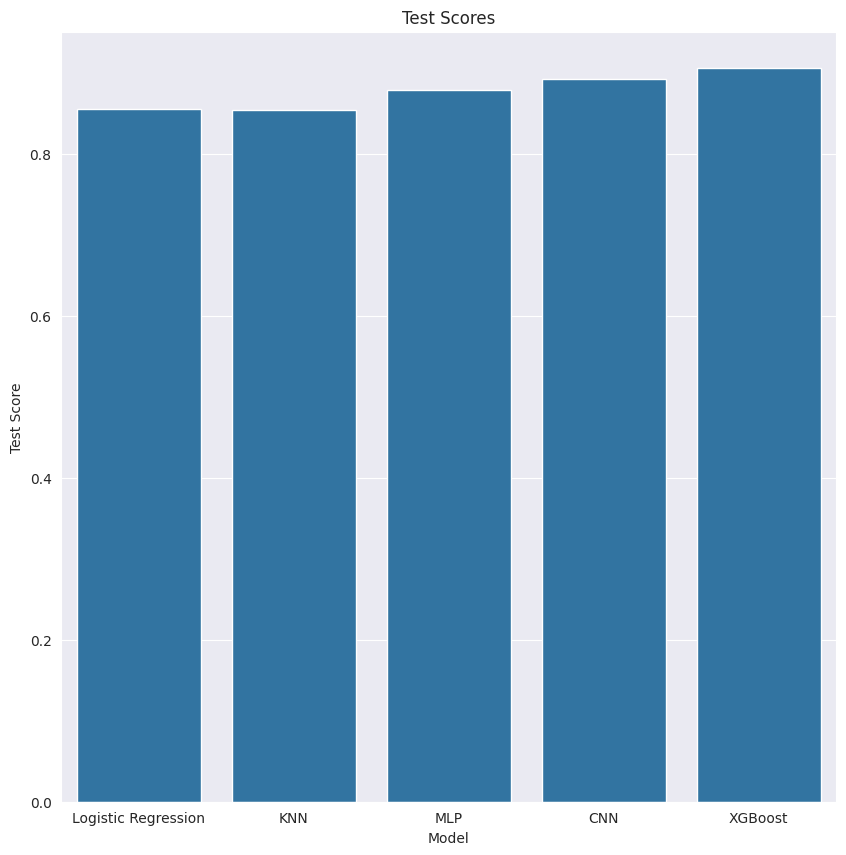

In [46]:
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
sns.barplot(x="Model", y="Test Score", data=test_scores)
plt.title("Test Scores")
plt.show()

# Insights

* Similar products are hard to distinguish over only pixels
* If there was a 3rd dimension with the rgb colors, maybe it would be easier to distinguish
* CNNs are basically constructed for image recognition hence shows good performance on test data.
* Max Pooling is reducing the matrix size twice and getting a denser, smaller matrix to feed
* XGBoost is another boosting method that uses decision trees and better when there are too many features to deter curse of dim.
* Lastly, image recognition is not my interest that much, hence I did not put much work as grid searching for better results or other convolution techniques.
* Winner is ***XGBoost***